# JobMap example
#### This notebook will go through an example of the following analysis:
    - estimating the distribution of occupations employed by a company of given size and industry
    - estimating the average salary of each occupation
    - simulating the potential job transitions given a pool of candidates and a pool of available jobs. 
    - The simulation assumes that:
        - candidates can only switch to jobs with similar skills
        - candidates would not take a job paying less than their current job

In [1]:
import pandas as pd
import sys
sys.path.append('../')
import jobmap
import matplotlib.pyplot as plt

Download a mapping from SOC to occupation description

In [2]:
soc_map=jobmap.get_soc_code_map('../data/soc_2018_definitions.xlsx')

In [3]:
print({k: soc_map[k] for k in list(soc_map.keys())[:10]})

{'110000': 'Management Occupations', '111000': 'Top Executives', '111010': 'Chief Executives', '111011': 'Chief Executives', '111020': 'General and Operations Managers', '111021': 'General and Operations Managers', '111030': 'Legislators', '111031': 'Legislators', '112000': 'Advertising, Marketing, Promotions, Public Relations, and Sales Managers', '112010': 'Advertising and Promotions Managers'}


# JobMap

### Create the JobMap object
- For this, we need the download the OESM data (all_data_M_2021.xlsx) from BLS. You can download the zip file from https://www.bls.gov/oes/special-requests/oesm21all.zip, load the data as a pandas dataframe and pass it to JobMap as 'bls_data'.
- We also need to specify the state code (eg. 'CA', MA'..)

In [4]:
bls_data=pd.read_excel('../data/oesm21all/all_data_M_2021.xlsx')

In [5]:
job_map=jobmap.JobMap(state_code='CA', bls_data=bls_data)

### Estimate the distribution of occupations per 1000 employed in an industry (or group of industries)

#### Scientific R&D

In [6]:
sci_naics_dict={'5417': 1000} 
sci_soc_dict= job_map.get_employees_by_soc(sci_naics_dict, as_dict=True)
sci_top_10_soc = dict(sorted(sci_soc_dict.items(), key=lambda x: x[1], reverse=True)[:10])
for soc in sci_top_10_soc:
    print('{} {} jobs'.format(sci_top_10_soc[soc], soc_map[soc]))

41 General and Operations Managers jobs
41 Medical Scientists, Except Epidemiologists jobs
39 Software Developers jobs
38 Social Science Research Assistants jobs
27 Natural Sciences Managers jobs
25 Biological Technicians jobs
23 Project Management Specialists jobs
23 Business Operations Specialists, All Other jobs
20 Secretaries and Administrative Assistants, Except Legal, Medical, and Executive jobs
19 Managers, All Other jobs


#### Grocery and Convenience Retailers

In [7]:
retail_naics_dict={'4451': 1000} 
retail_soc_dict= job_map.get_employees_by_soc(retail_naics_dict, as_dict=True)
retail_top_10_soc = dict(sorted(retail_soc_dict.items(), key=lambda x: x[1], reverse=True)[:10])
for soc in retail_top_10_soc:
    print('{} {} jobs'.format(retail_top_10_soc[soc], soc_map[soc]))

345 Cashiers jobs
160 Stockers and Order Fillers jobs
101 Retail Salespersons jobs
73 First-Line Supervisors of Retail Sales Workers jobs
39 Food Preparation Workers jobs
30 Fast Food and Counter Workers jobs
25 Customer Service Representatives jobs
25 Butchers and Meat Cutters jobs
24 General and Operations Managers jobs
22 Packers and Packagers, Hand jobs


# Job Transitioner

In [8]:
job_trans=jobmap.JobTransitioner()

### Estimate potential job transitions from a talent pool (existing occupations) to a set of new jobs

In [9]:
candidates=pd.DataFrame(job_map.get_job_list(sci_soc_dict))
jobs=pd.DataFrame(job_map.get_job_list(retail_soc_dict))

candidate_soc_mat=job_trans.soc_list_to_matrix(candidates['soc'])
job_soc_mat=job_trans.soc_list_to_matrix(jobs['soc'])

# identify any job transitions that would mean a drop in salary
ind_salary_decrease=job_trans.get_salary_decrease_mat(
    candidates['salary'], jobs['salary'])

print('Attempting to match {} jobs from {} candidates'.format(
    len(jobs), len(candidates)))
transitions=job_trans.match_jobs(
    from_soc_mat=candidate_soc_mat,  to_soc_mat=job_soc_mat, 
    salary_decrease=ind_salary_decrease)
print('\t {} matches made'.format(len(transitions)))

Attempting to match 997 jobs from 996 candidates
	 81 matches made


In [10]:
transitions

,row_ind,col_ind,cost
5,5,3,0.0
6,6,4,0.0
7,7,5,0.0
8,8,6,0.0
9,9,7,0.0
...,...,...,...
982,982,741,0.0
988,988,785,0.0
992,992,786,0.0
993,993,805,0.0


# Create a more readable output

In [11]:
transitions=transitions.set_index('col_ind', drop=True)

jobs_assignment=jobs.merge(transitions,
               left_index=True, right_index=True, how='left').rename(
    columns={'soc': 'soc_new', 'salary': 'salary_new'
})

jobs_assignment_successful=jobs_assignment.dropna(subset=['row_ind']).copy()
jobs_assignment_successful['row_ind']=jobs_assignment_successful['row_ind'].astype(int)

jobs_assignment_successful=jobs_assignment_successful.merge(
    candidates, left_on='row_ind', right_index=True, how='left').rename(
    columns={'soc': 'soc_old', 'salary': 'salary_old'
})

In [12]:
jobs_assignment_successful

,soc_new,salary_new,row_ind,cost,soc_old,salary_old
0,111021,107850.0,26,0.0,111021,107850.0
1,111021,107850.0,27,0.0,111021,107850.0
2,111021,107850.0,28,0.0,111021,107850.0
3,111021,107850.0,5,0.0,111021,107850.0
4,111021,107850.0,6,0.0,111021,107850.0
...,...,...,...,...,...,...
785,519012,48020.0,988,0.0,519023,44140.0
786,519111,36640.0,992,0.0,519199,36590.0
805,536031,30950.0,993,0.0,537061,30330.0
806,536031,30950.0,975,0.0,452092,29680.0


# Visualize filled and unfilled jobs

In [13]:
jobs_assignment

,soc_new,salary_new,row_ind,cost
0,111021,107850.0,26.0,0.0
1,111021,107850.0,27.0,0.0
2,111021,107850.0,28.0,0.0
3,111021,107850.0,5.0,0.0
4,111021,107850.0,6.0,0.0
...,...,...,...,...
992,537065,36060.0,NaN,NaN
993,537065,36060.0,NaN,NaN
994,537065,36060.0,NaN,NaN
995,537065,36060.0,NaN,NaN


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
sns.set(font_scale=2)
# plt.style.use("dark_background")

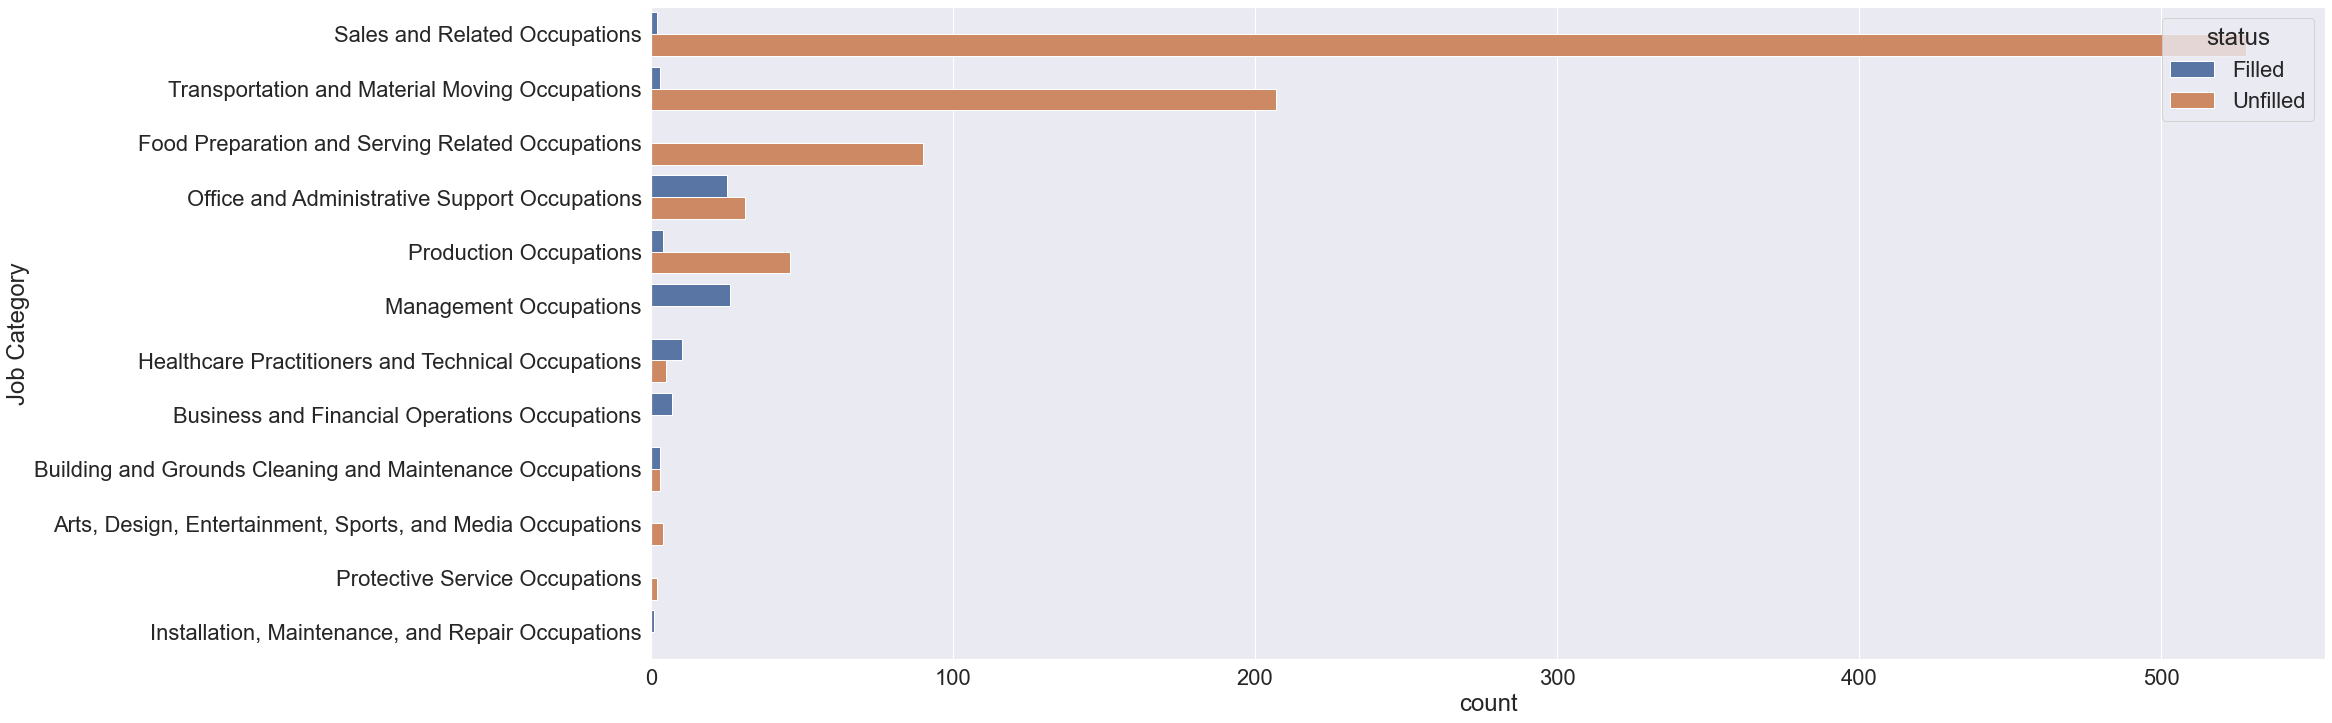

In [16]:
jobs_assignment['soc_2']=(jobs_assignment['soc_new'].astype(int).floordiv(10000)*10000).astype(str)
fig, ax = plt.subplots(1, figsize=(30,len(jobs_assignment['soc_2'].unique())))
jobs_assignment['Job Category']=jobs_assignment['soc_2'].apply(lambda x: soc_map[x])
jobs_assignment['status']='Unfilled'
jobs_assignment.loc[~(jobs_assignment['row_ind'].isnull()), 'status']='Filled'
order=jobs_assignment['Job Category'].value_counts().index
p = sns.countplot(data=jobs_assignment, y='Job Category', hue='status', ax=ax, 
                      order=order, hue_order=['Filled', 'Unfilled'])

# Visualize Job Transitions

In [17]:
import plotly.graph_objects as go
import plotly

In [20]:
job_od=jobs_assignment_successful.groupby(
    ['soc_old', 'soc_new']).size().reset_index(drop=False)

In [22]:
source_labels=[soc_map[s] + '_s' for s in job_od['soc_old'].unique()]
target_labels=[soc_map[t] + '_t' for t in job_od['soc_new'].unique()]
all_labels=source_labels+target_labels
value=list(job_od[0])

source=[all_labels.index(soc_map[s] + '_s') for s in job_od['soc_old']]
target=[all_labels.index(soc_map[t] + '_t') for t in job_od['soc_new']]

fig = go.Figure(data=[go.Sankey(textfont = dict(color="white"),
    node=dict(
        thickness=10,  # default is 20
        line=dict(color="white", width=0.5),
        label=[l.split('_')[0] for l in all_labels],
        color="blue"
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        label=[l.split('_')[0] for l in all_labels],
        hovertemplate='%{value} from %{source.label} to %{target.label}.<br />'
    ))])

# fig.update_layout(autosize=True)
# fig.show()

fig.update_layout(
#         autosize=True,
    width=1000,
    height=len(source)*30,
plot_bgcolor = 'black',
paper_bgcolor = 'black')

fig.show(renderer='browser')